# Q-Learning Lab
In this lab, you will learn about Q-Learning. You will write a training function and learn how training affects performance.

### Setup and install any dependencies

In [ ]:
# !pip install pygame
# !pip install numpy
!pip install gymnasium

In [ ]:
import numpy as np
import gymnasium as gym
import random
import imageio
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Create the FrozenLake-v1 environment using 4x4 map and non-slippery version
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode='rgb_array')
env.reset()

(0, {'prob': 1})

#### Understanding the Frozen Lake environment

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 13


In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Get a random action


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 2


#### Let's look at the environment

We want our character to get to the present without falling in the ice holes.

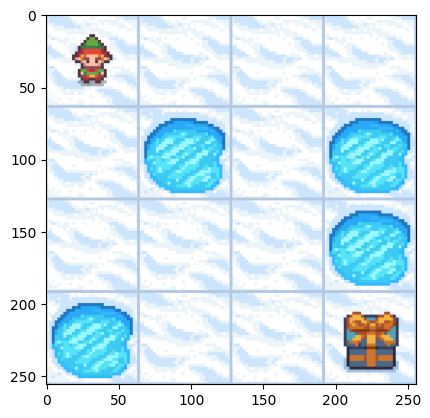

In [ ]:
plt.imshow(env.render())

#### Create and Initialize the Q-Table

In [ ]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

Qtable_frozenlake = initialize_q_table(state_space, action_space)
print("Q-Table \n", Qtable_frozenlake)

There are  16  possible states
There are  4  possible actions
Q-Table 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#### Define a function to display the q-table values on the world

In [ ]:
def visualize_q_table(q_table, env, use_best_action=False):
    """
    Visually displays the Q-table values for a grid observation space using row-major order.
    Automatically extracts and displays state types (F, H, G, etc.) from the Gym environment.
    Highlights the best Q-value in each state.

    Parameters:
    - q_table: A numpy array of shape (num_states, num_actions), where each state has Q-values for [left, down, right, up].
    - env: The OpenAI Gymnasium environment.
    - use_best_action: If True, displays the best action in each state instead of the state label.
    """
    # Extract grid shape from the environment
    rows, cols = env.unwrapped.desc.shape

    # Extract state labels (F, H, G, etc.)
    state_labels = list(env.unwrapped.desc.astype(str).flatten())  # No transposition needed

    fig, ax = plt.subplots(figsize=(cols * 2.0, rows * 2.0))  # Larger cells for readability
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    action_labels = ['←', '↓', '→', '↑']  # Left, Down, Right, Up

    for i in range(rows):  # Iterate over rows first (Row-Major Order)
        for j in range(cols):  # Then iterate over columns
            state = i * cols + j  # Row-major order indexing
            q_values = q_table[state]
            best_action = np.argmax(q_values)  # Find the index of the best Q-value

            # Draw grid cell
            rect = patches.Rectangle((j, rows - i - 1), 1, 1, linewidth=1, edgecolor='black', facecolor='white')
            ax.add_patch(rect)

            # Choose what to display in the center of the cell
            if use_best_action:
                center_text = action_labels[best_action]  # Show best action direction
            else:
                center_text = state_labels[state]  # Show environment label (F, H, G, etc.)

            # Display the state label in the center of the cell
            ax.text(j + 0.5, rows - i - 0.5, center_text, ha='center', va='center',
                    fontsize=12, fontweight='bold', color='red' if center_text == 'H' else 'blue')

            # Position Q-values within the cell (highlight best in bold)
            for action_idx, (dx, dy) in enumerate([(0.2, -0.5), (0.5, -0.85), (0.75, -0.5), (0.5, -0.15)]):
                value_text = f"{action_labels[action_idx]} {q_values[action_idx]:.2f}"
                font_weight = 'bold' if action_idx == best_action else 'normal'  # Highlight best Q-value
                ax.text(j + dx, rows - i + dy, value_text, ha='center', fontsize=10, fontweight=font_weight)

    plt.show()

#### Let's try it with our q-table
Note that all the q-values are 0 at this time.

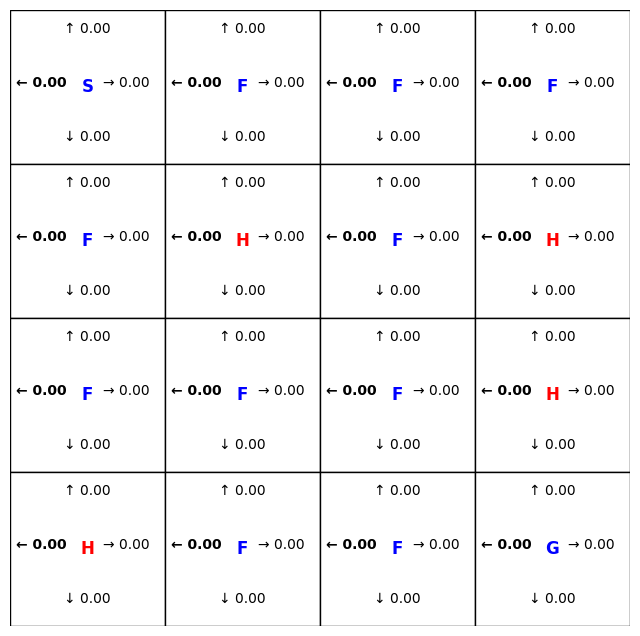

In [ ]:
# Use our display function to visualize the Q-table
visualize_q_table(Qtable_frozenlake, env)

#### Define the epsilon-greedy policy and the greedy policy

In [ ]:
def get_valid_actions(env, state):
    """
    Given an OpenAI Gymnasium environment and current state,
    determines valid actions that can be taken from a given state in a grid-based environment.

    Parameters:
    - env: The OpenAI Gymnasium environment.
    - state: The current state index (integer).

    Returns:
    - A list of valid action indices (0: left, 1: down, 2: right, 3: up).
    """
    rows, cols = env.unwrapped.desc.shape  # Get grid dimensions
    row, col = divmod(state, cols)  # Convert state index to (row, col)

    valid_actions = []

    action_offsets = {
        0: (0, -1),  # Left
        1: (1, 0),   # Down
        2: (0, 1),   # Right
        3: (-1, 0)   # Up
    }


    for action, (dr, dc) in action_offsets.items():
        new_row, new_col = row + dr, col + dc

        if 0 <= new_row < rows and 0 <= new_col < cols:  # Check if inside grid bounds
            new_state = new_row * cols + new_col
            if env.unwrapped.desc[new_row, new_col] != b'H':  # Prevent moving into holes
                valid_actions.append(action)

    return valid_actions

def epsilon_greedy_policy(Qtable, state, epsilon, env):
  # Randomly generate a number between 0 and 1
  random_int = random.uniform(0,1)
  # if random_int > greater than epsilon --> exploitation
  if random_int > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = np.argmax(Qtable[state])
  # else --> exploration
  else:
    # Get the list of valid actions
    valid_actions = get_valid_actions(env, state)
    # Randomly select an action from the list of valid actions
    action = random.choice(valid_actions)
    # action = random.randint(0, env.action_space.n - 1)

  return action


def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state])

  return action

#### Functions to train the Q-Learning model

### Part 1) (40%) Your Task
Your task is, given the previous functions, write the training function which should:

Go through a number of episodes. In each episode,
<ul>
    <li> reduce the epsilon appropriately because we want to lessen the exploration possibilities as we go on
    <li> reset the environment and put us at the beginning. For the frozen lake, you would use <pre>state = env.reset()[0]</pre> because reset returns an array of things. We want the first element.
    <li> Then, for this episode, go a number of steps to see if we find the goal state
        <ul>
        <li> Choose an action to take according to which policy you are using: greedy or epsilon_greedy
        <li> Take that step in the environment using <pre>new_state, reward, done, truncated, info = env.step(action)</pre> which returns the new state and reward and whether or not you are done.
        <li> Use the returned values to update your QTable using the Bellman Equation
        <li> Update your state variable
        </ul>
</ul>


In [ ]:
def Bellman_update(Qtable, state, action, reward, next_state, gamma, learning_rate):
  curr_q_value = Qtable[state][action]
  best_future_q_value = np.max(Qtable[next_state])
  new_q_value = curr_q_value + learning_rate * (reward + (gamma * best_future_q_value) - curr_q_value )
  Qtable[state][action] = new_q_value
  return Qtable

In [ ]:
# train the model - the end result will be our updated Q-Table
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable):

  for episode in range(n_training_episodes):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    state = env.reset()[0]

    for step in range(max_steps):
      action = epsilon_greedy_policy(Qtable, state, epsilon, env)
      new_state, reward, done, truncated, info = env.step(action)


      Qtable = Bellman_update(Qtable, state, action, reward, new_state, gamma, learning_rate)
      state = new_state

      if done:
        break

  return Qtable

#### Define the hyperparameters we will use

In [ ]:
# Training parameters
n_training_episodes = 100    # Total training episodes
learning_rate = 0.85         # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 100              # Max steps per episode
gamma = 0.98                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [ ]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable_frozenlake)

#### Visualize the trained Q-Table

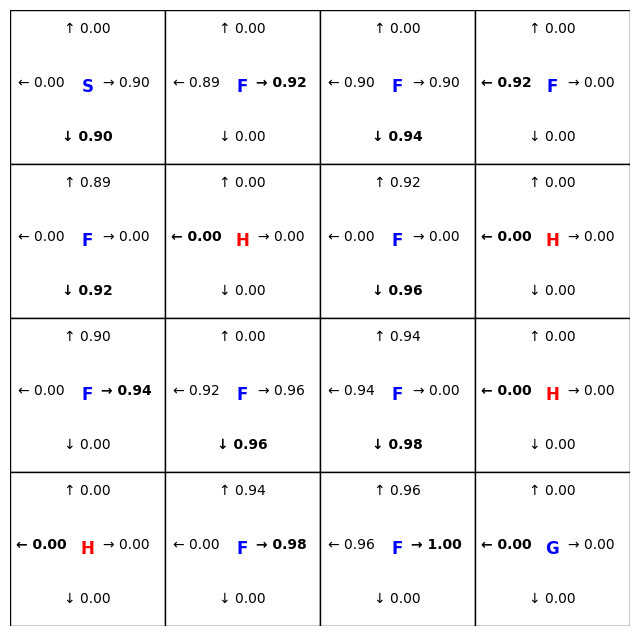

In [ ]:
visualize_q_table(Qtable_frozenlake, env)

#### How does the model perform on average?

In [ ]:
# Evaluate the agent by running the environment for n_eval_episodes
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])[0] # reset returns a tuple, but we only need the array
    else:
      state = env.reset()[0] # reset returns a tuple, but we only need the array
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Q[state][:])
      new_state, reward, done, truncated, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [ ]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


#### Part 2) (10%) Training vs Reward
Write a function to plot the mean_reward vs training iterations

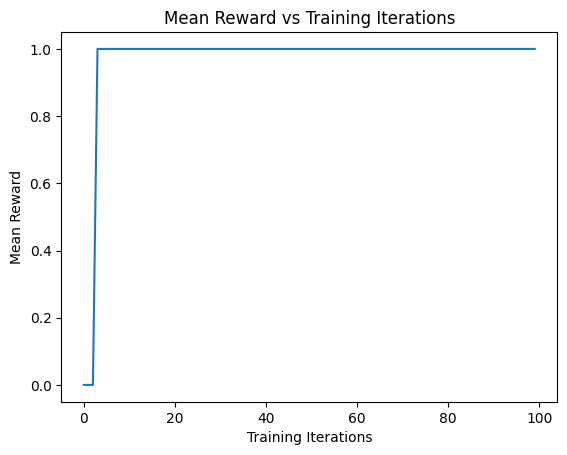

In [ ]:
def plot_mean_reward_vs_training_iterations(n_training_episodes, min_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable_frozenlake, eval_seed, state_space, action_space):
  rewards = []
  for i in range(n_training_episodes):
    Qtable_frozenlake = initialize_q_table(state_space, action_space)
    Qtable_frozenlake = train(i + 1, min_epsilon, max_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable_frozenlake)
    mean_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)[0]
    rewards.append(mean_reward)
  plt.plot(rewards)
  plt.xlabel('Training Iterations')
  plt.ylabel('Mean Reward')
  plt.title('Mean Reward vs Training Iterations')
  plt.show()

plot_mean_reward_vs_training_iterations(n_training_episodes, min_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable_frozenlake, eval_seed, state_space, action_space)

#### (5%) Discussion
How did the model do? What happens when you change the number of iterations it trains? How does the final QTable differ from the initial training of 100 iterations?

The model did very well and this was to be expected with `is_slippery=False`. For this, not much would happen if you change the number of iteration since it found the reward very early on via the plot above ^^

#### Part 3) (40%) Now let's do it on a slippery lake
The slippery lake makes it so sometimes you don't go the way you think you will. We will need to do it with a custom map. It won't do very well with the default map

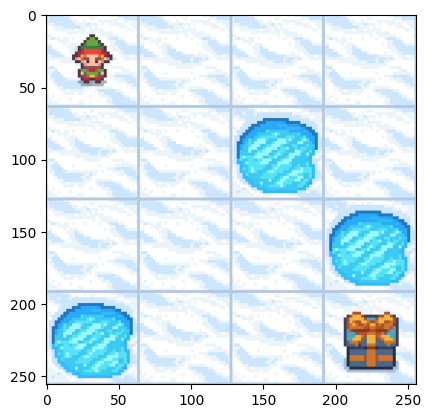

In [ ]:
# Define and show the custom map
custom_map=["SFFF", "FFHF", "FFFH", "HFFG"]
env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery=True, render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

#### Initialize the Q-Table

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Get a random action

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 15

 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 0


There are  16  possible states
There are  4  possible actions
Q-Table 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


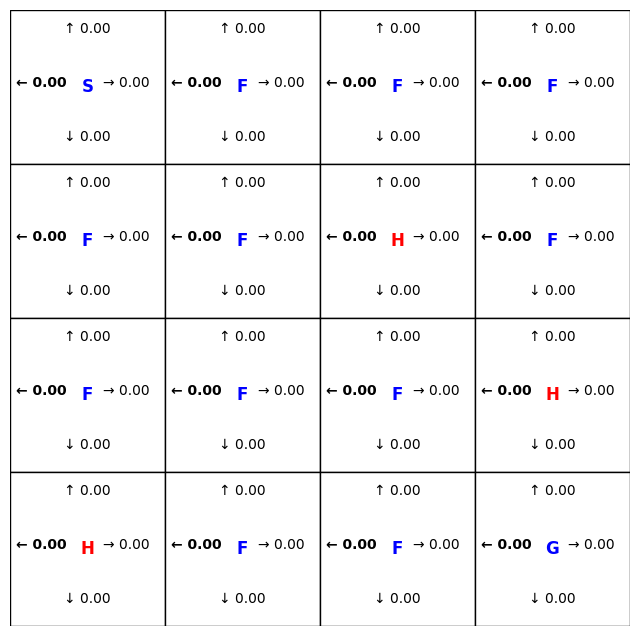

In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

Qtable_frozenlake_slippery = initialize_q_table(state_space, action_space)
print("Q-Table \n", Qtable_frozenlake_slippery)

visualize_q_table(Qtable_frozenlake_slippery, env)

#### Set up the parameters, train the model, and evaluate

#### Show the Q-Table

In [ ]:
Qtable_frozenlake_slippery = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable_frozenlake_slippery)

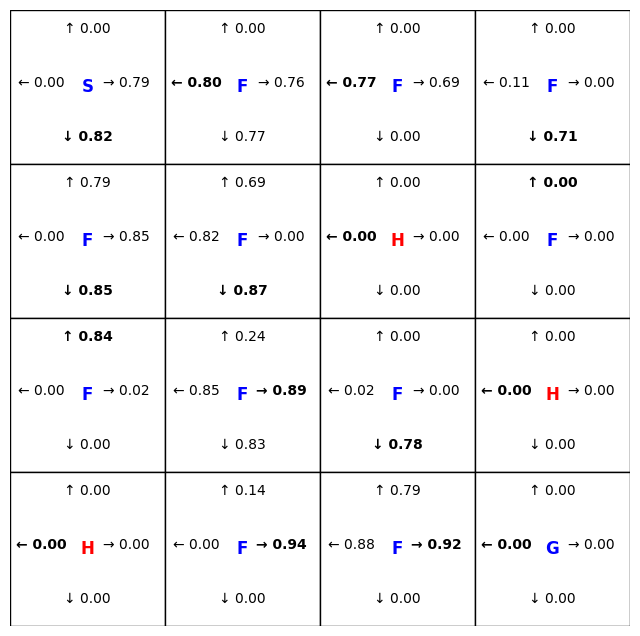

In [ ]:
visualize_q_table(Qtable_frozenlake_slippery, env)

In [ ]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake_slippery, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=0.18 +/- 0.38


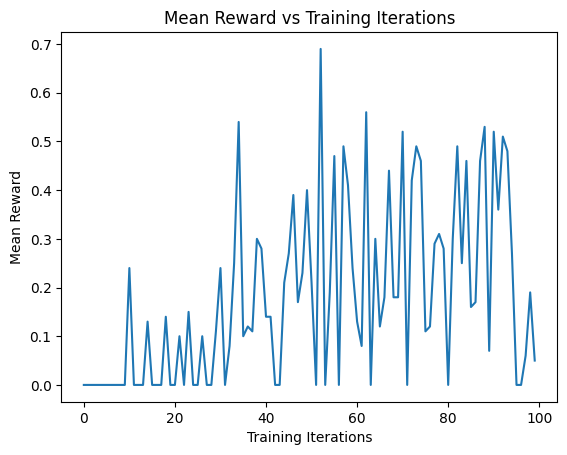

In [ ]:
plot_mean_reward_vs_training_iterations(n_training_episodes, min_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable_frozenlake_slippery, eval_seed, state_space, action_space)

#### Now, play with the map and see what happens.
You will need to define a new map and setup a new QTable and then train and evaluate.

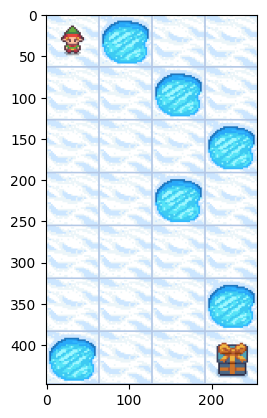

In [ ]:
# Define and show the custom map
custom_map=["SHFF",
            "FFHF",
            "FFFH",
            "FFHF",
            "FFFF",
            "FFFH",
            "HFFG"]
env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery=True, render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

_____OBSERVATION SPACE_____ 

Observation Space Discrete(28)
Sample observation 20

 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 3
There are  28  possible states
There are  4  possible actions
Q-Table 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


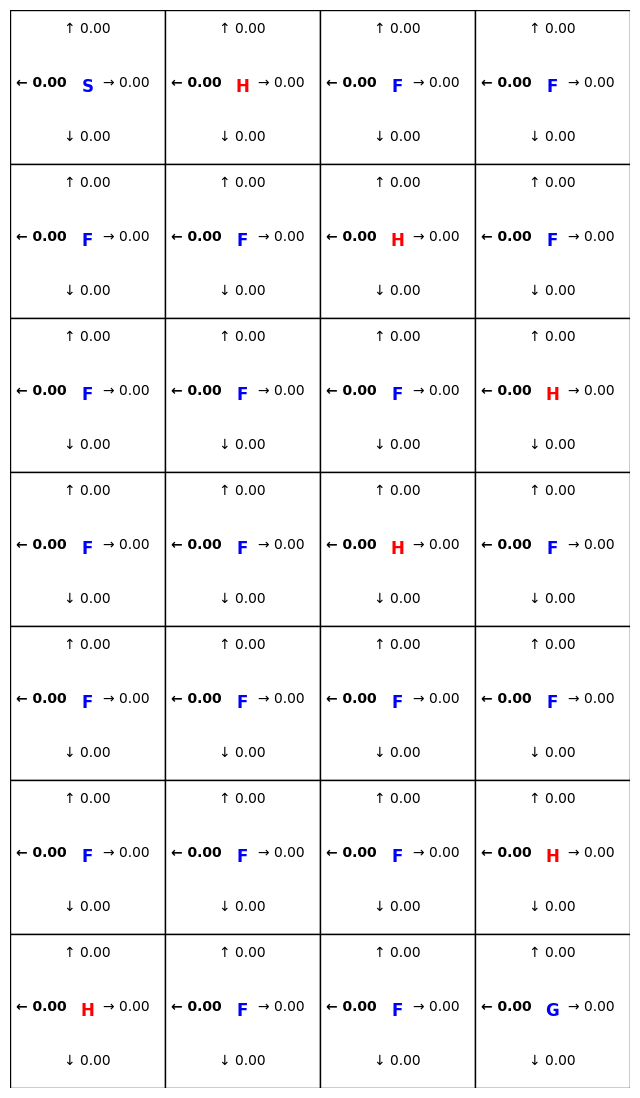

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Get a random action

state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

Qtable_frozenlake_custom = initialize_q_table(state_space, action_space)
print("Q-Table \n", Qtable_frozenlake_custom)

visualize_q_table(Qtable_frozenlake_custom, env)

In [ ]:
max_steps=300
n_training_episodes = 500

Qtable_frozenlake_custom = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable_frozenlake_custom)

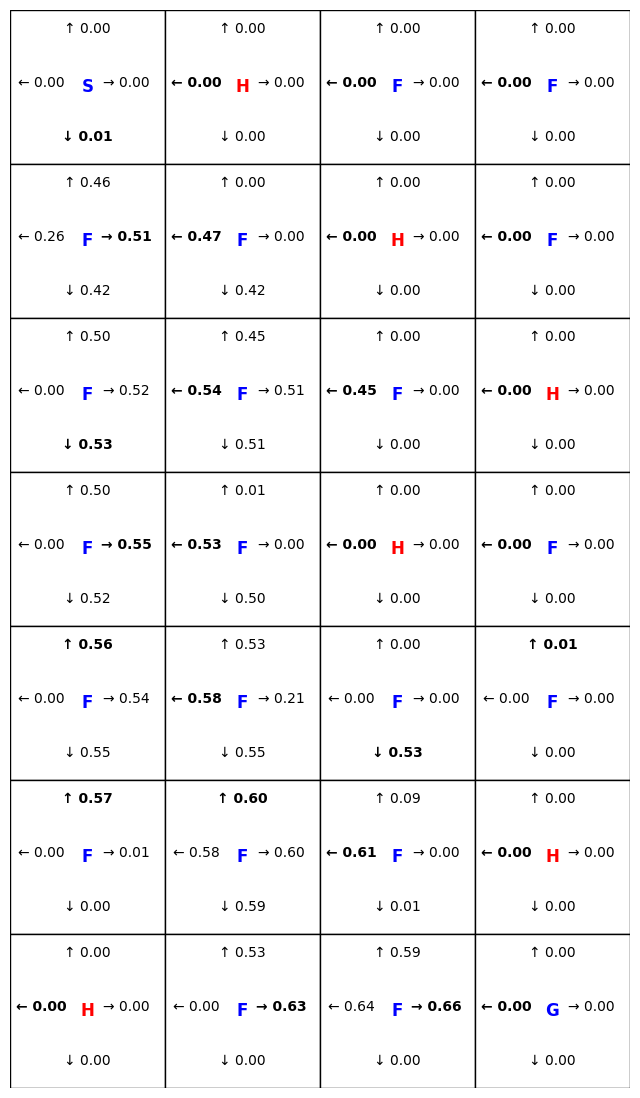

In [ ]:
visualize_q_table(Qtable_frozenlake_custom, env)

In [ ]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake_custom, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=0.08 +/- 0.27


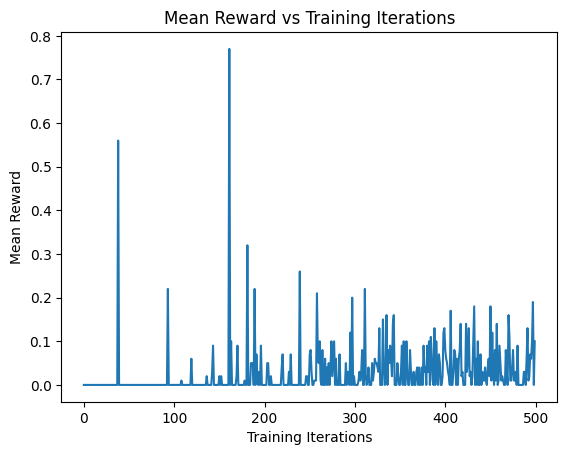

In [ ]:
plot_mean_reward_vs_training_iterations(n_training_episodes, min_epsilon, decay_rate, learning_rate, gamma, env, max_steps, Qtable_frozenlake_custom, eval_seed, state_space, action_space)

#### (5%) Discussion
What did you learn? What happens when you played with the map on the slippery lake?

At first I made the map VERY complex (essentially just 2 direct paths and a lot more rows and columns) and the agent couldn't reach the goal, so I basically had to dumb down the map a lot. I even increased the number of episodes and steps significantly but couldn't find it when `is_slipery=True`. When it was `is_slipery=False`, I was able to reach the goal on the difficult map. I had to go back to the docs and figure out exactly what `is_slipery` was doing. Apparently, If True will move in intended direction with probability of 1/3. That is why it was having such a hard time.